<a href="https://colab.research.google.com/github/saqlineniam/Real-Time-Apple-Detection-for-Robust-Multi-Object-Tracking-in-Orchard-Environments/blob/main/Tomato_Training_the_Yolo_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 38.5 MB/s eta 0:00:00


In [ ]:
import torch
print(f"Setup Complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup Complete. Using torch 2.9.0+cu126 (Tesla T4)


In [ ]:
# !pip install roboflow
# from roboflow import Roboflow
# rf = Roboflow(api_key="YOUR_API_KEY")
# project = rf.workspace("workspace-name").project("project-name")
# version = project.version(1)
# dataset = version.download("yolov8")

In [ ]:
import zipfile
import os

# Change 'dataset.zip' if your file is named differently
zip_path = '/content/dataset.zip'

if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('/content/dataset')
    print("✅ Unzipped successfully!")
else:
    print("❌ Zip file not found. Did you drag and drop it into the left sidebar?")

In [ ]:
import yaml

# Path to your data.yaml
yaml_path = '/content/drive/MyDrive/AppleMOT_YOLOv8_bbox/data.yaml'

# Read the file
with open(yaml_path, 'r') as f:
    data = yaml.safe_load(f)

# Fix the paths to be absolute for Colab
data['path'] = '/content/drive/MyDrive/AppleMOT_YOLOv8_bbox'
data['train'] = '/content/drive/MyDrive/AppleMOT_YOLOv8_bbox/images/train'
data['val'] = '/content/drive/MyDrive/AppleMOT_YOLOv8_bbox/images/val'
# data['test'] = 'test/images' # Optional

# Save it back
with open(yaml_path, 'w') as f:
    yaml.dump(data, f)

print("✅ data.yaml fixed for Colab!")

✅ data.yaml fixed for Colab!


In [ ]:
from ultralytics import YOLO

# Load the pretrained small model
model = YOLO('yolov8s.pt')

# Train
results = model.train(
    data='/content/drive/MyDrive/AppleMOT_YOLOv8_bbox/data.yaml',  # Path to the yaml we fixed
    epochs=100,                         # 100 epochs is standard
    imgsz=1280,                         # High resolution for drone
    batch=8,                            # Low batch size to prevent OutOfMemory
    project='/content/runs',            # Save results here
    name='tomato_drone_model',          # Folder name
    patience=15,                        # Stop early if no improvement
    verbose=True
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/AppleMOT_YOLOv8_bbox/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1280, in

In [ ]:
from IPython.display import Image, display

# 1. Show the Training Graph (Loss vs Epochs)
print("--- Training Metrics ---")
display(Image(filename='/content/runs/tomato_drone_model/results.png'))

# 2. Show the Model detecting tomatoes on validation data
# It usually saves a batch prediction jpg
import glob
val_images = glob.glob('/content/runs/tomato_drone_model/val_batch0_pred.jpg')

if val_images:
    print("\n--- Model Predictions ---")
    display(Image(filename=val_images[0]))
else:
    print("Could not find validation image.")

In [ ]:
from ultralytics import YOLO
import pandas as pd

# ==========================================
# 1. SETUP
# ==========================================
# Point this to your trained weights file
model_path = '/content/runs/tomato_drone_model/weights/best.pt'

# Point this to your data.yaml file
data_yaml_path = '/content/drive/MyDrive/AppleMOT_YOLOv8_bbox/data.yaml'

# Load the model
model = YOLO(model_path)

# ==========================================
# 2. RUN VALIDATION
# ==========================================
print("Running validation to calculate exact metrics...")
metrics = model.val(data=data_yaml_path, verbose=False)

# ==========================================
# 3. EXTRACT METRICS
# ==========================================
# Ultralytics stores metrics in the .box attribute
p = metrics.box.mp   # Mean Precision
r = metrics.box.mr   # Mean Recall
map50 = metrics.box.map50  # mAP at 0.5 IoU
map95 = metrics.box.map    # mAP at 0.5:0.95 IoU

# Create a DataFrame for the Paper
results_df = pd.DataFrame({
    'Metric': ['Precision (P)', 'Recall (R)', 'mAP@50', 'mAP@50-95'],
    'Value': [p, r, map50, map95],
    'Description': [
        'Accuracy of positive predictions (Few false alarms)',
        'Ability to find all tomatoes (Few missed targets)',
        'Standard accuracy metric (IoU=0.50)',
        'High-precision accuracy metric (IoU=0.50:0.95)'
    ]
})

# Format to 4 decimal places
results_df['Value'] = results_df['Value'].apply(lambda x: round(x, 4))

# ==========================================
# 4. DISPLAY TABLE
# ==========================================
print("\n--- TABLE 1: Detection Model Performance ---")
display(results_df)

# Hint: Copy these numbers into the Table 1 I gave you in the previous prompt.

Running validation to calculate exact metrics...
Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 176.1±121.1 MB/s, size: 2332.0 KB)
val: Scanning /content/drive/MyDrive/AppleMOT_YOLOv8_bbox/labels/val.cache... 1051 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1051/1051 1.6Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 66/66 1.1s/it 1:11
                   all       1051      45011      0.786      0.736      0.814      0.524
Speed: 5.9ms preprocess, 27.5ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to /content/runs/detect/val

--- TABLE 1: Detection Model Performance ---


,Metric,Value,Description
0,Precision (P),0.7859,Accuracy of positive predictions (Few false al...
1,Recall (R),0.7359,Ability to find all tomatoes (Few missed targets)
2,mAP@50,0.8140,Standard accuracy metric (IoU=0.50)
3,mAP@50-95,0.5242,High-precision accuracy metric (IoU=0.50:0.95)


Loading plots from: /content/runs/detect/val

--- Figure 1: Confusion Matrix ---


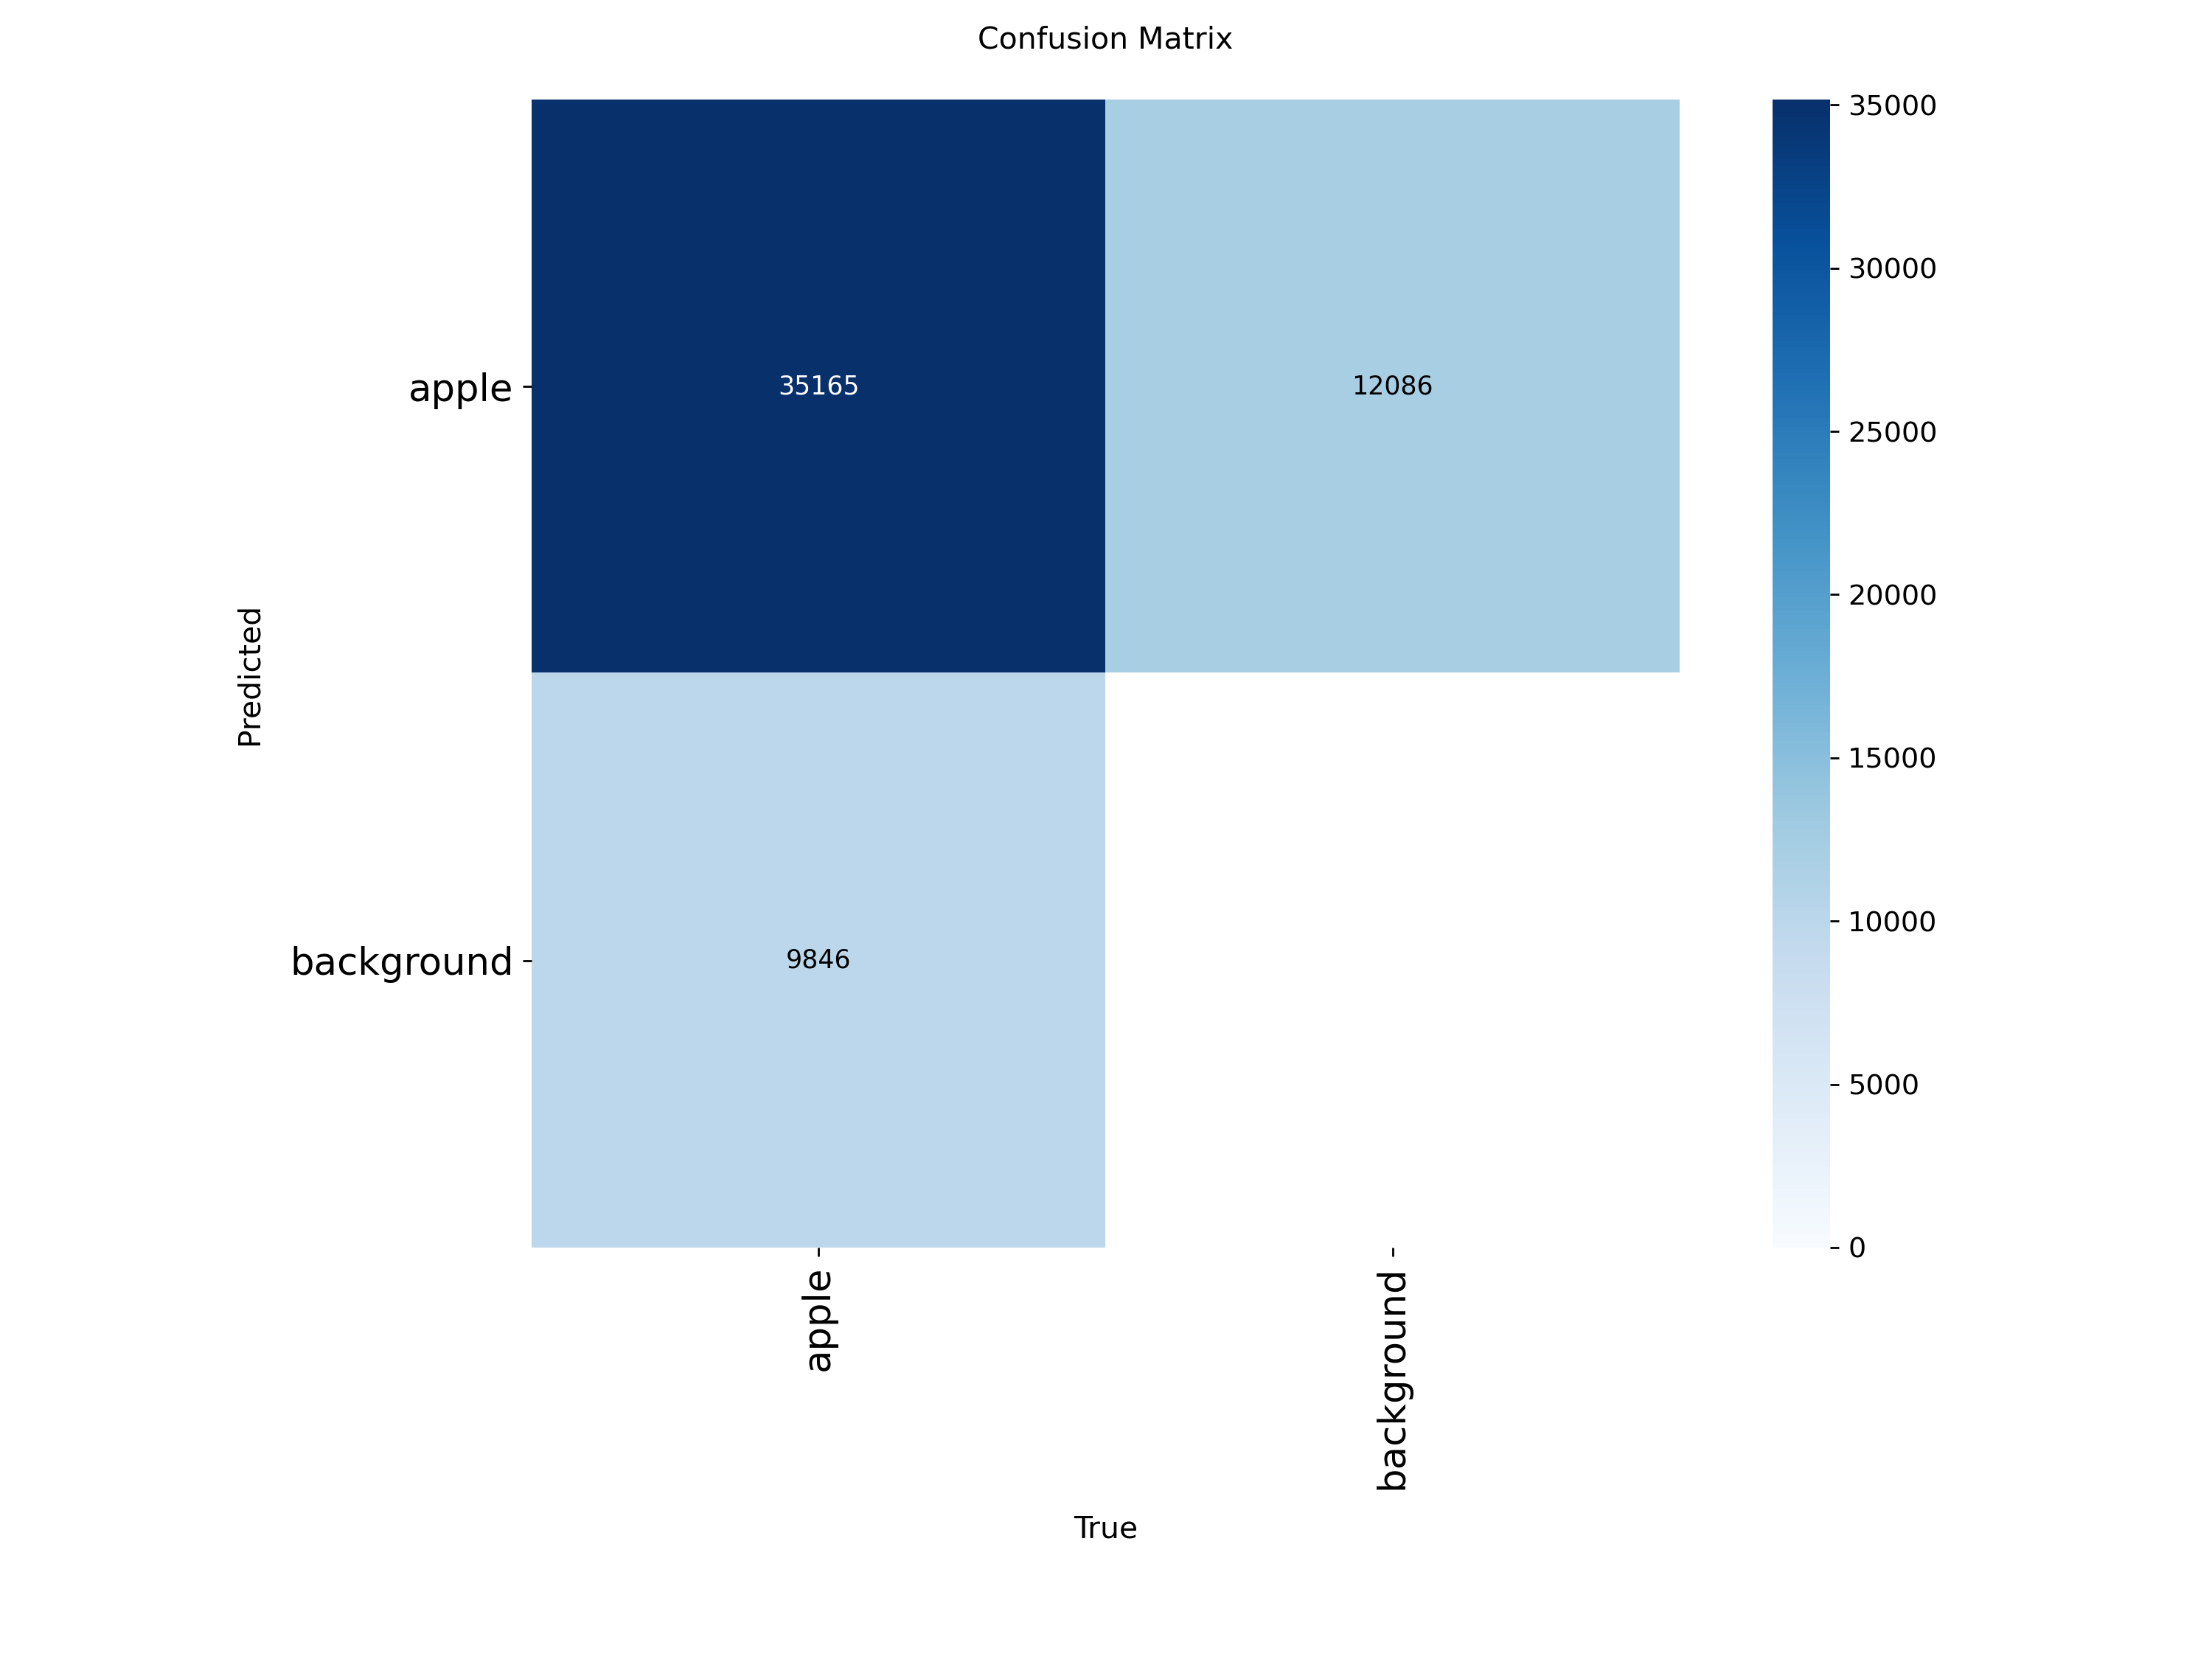

Could not find PR_curve.png. Did you run validation?
Could not find F1_curve.png. Did you run validation?


In [ ]:
import os
from IPython.display import Image, display

# Find the latest validation folder where YOLO saved the plots
# usually runs/detect/val, val2, val3, etc.
# We will check the directory created by the previous step
save_dir = metrics.save_dir # This gets the path automatically

print(f"Loading plots from: {save_dir}")

def show_plot(filename, title):
    filepath = os.path.join(save_dir, filename)
    if os.path.exists(filepath):
        print(f"\n--- {title} ---")
        display(Image(filename=filepath, width=600))
    else:
        print(f"Could not find {filename}. Did you run validation?")

# 1. Confusion Matrix
# Shows if tomatoes are being confused with background or markers
show_plot('confusion_matrix.png', 'Figure 1: Confusion Matrix')

# 2. Precision-Recall Curve (PR Curve)
# The area under this curve is your mAP. Ideally, it hugs the top-right corner.
show_plot('PR_curve.png', 'Figure 2: Precision-Recall Curve')

# 3. F1-Confidence Curve
# Shows the balance between Precision and Recall at different confidence thresholds.
show_plot('F1_curve.png', 'Figure 3: F1-Score vs Confidence')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Path to the results.csv file (Generated during TRAINING, not validation)
# Adjust path if your training folder name is different
csv_path = '/content/runs/detect/tomato_drone_model/results.csv'

try:
    # Read the CSV (YOLO puts extra spaces in column names, so we strip them)
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.strip()

    plt.figure(figsize=(12, 5))

    # Plot 1: Box Loss (How well it draws the box)
    plt.subplot(1, 2, 1)
    plt.plot(df['epoch'], df['train/box_loss'], label='Train Loss', color='blue')
    plt.plot(df['epoch'], df['val/box_loss'], label='Validation Loss', color='orange')
    plt.title('Bounding Box Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot 2: mAP@50 (Accuracy over time)
    plt.subplot(1, 2, 2)
    plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@50', color='green')
    plt.title('Mean Average Precision (mAP@50)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print("Save this image as 'Figure_Training_Performance.png' for your paper.")

except FileNotFoundError:
    print(f"Could not find {csv_path}. Please check the path to your training run.")

In [ ]:
!zip -r my_output_filename.zip runs

  adding: runs/ (stored 0%)
  adding: runs/detect/ (stored 0%)
  adding: runs/detect/val/ (stored 0%)
  adding: runs/detect/val/val_batch2_labels.jpg (deflated 2%)
  adding: runs/detect/val/confusion_matrix.png (deflated 32%)
  adding: runs/detect/val/val_batch2_pred.jpg (deflated 2%)
  adding: runs/detect/val/BoxR_curve.png (deflated 17%)
  adding: runs/detect/val/confusion_matrix_normalized.png (deflated 36%)
  adding: runs/detect/val/val_batch1_pred.jpg (deflated 2%)
  adding: runs/detect/val/BoxF1_curve.png (deflated 17%)
  adding: runs/detect/val/val_batch0_pred.jpg (deflated 2%)
  adding: runs/detect/val/BoxPR_curve.png (deflated 18%)
  adding: runs/detect/val/val_batch1_labels.jpg (deflated 2%)
  adding: runs/detect/val/val_batch0_labels.jpg (deflated 2%)
  adding: runs/detect/val/BoxP_curve.png (deflated 18%)
  adding: runs/tomato_drone_model/ (stored 0%)
  adding: runs/tomato_drone_model/val_batch2_labels.jpg (deflated 2%)
  adding: runs/tomato_drone_model/train_batch2.jpg (de

Make Video from Image

In [ ]:
import cv2
import os
from ultralytics import YOLO

# ==========================================
# CONFIGURATION
# ==========================================
# Path to the folder where your images are stored
image_folder = '/content/drive/MyDrive/AppleMOT_YOLOv8_bbox/images/val'  # <--- UPDATE THIS PATH

# The prefix to look for
file_prefix = '0006_'

# Output video filename
output_video_name = 'sequence_0006.mp4'
fps = 15  # Frame rate (usually 30 for drones)

# ==========================================
# STEP 1: MAKE VIDEO FROM IMAGES
# ==========================================
print(f"Searching for images starting with '{file_prefix}' in {image_folder}...")

# Get all files that start with 0006_ and end with .jpg or .png
images = [img for img in os.listdir(image_folder) if img.startswith(file_prefix) and img.endswith((".jpg", ".png", ".jpeg"))]

# CRITICAL: Sort the images so the video plays in the right order!
images.sort()

if not images:
    print("❌ Error: No images found! Check your path and prefix.")
else:
    print(f"✅ Found {len(images)} frames. Stitching video...")

    # Read the first image to get width and height
    frame_path = os.path.join(image_folder, images[0])
    frame = cv2.imread(frame_path)
    height, width, layers = frame.shape

    # Initialize the Video Writer
    # 'mp4v' is the codec for .mp4
    video = cv2.VideoWriter(output_video_name, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    # Loop through images and write to video
    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    cv2.destroyAllWindows()
    video.release()
    print(f"✅ Video saved as: {output_video_name}")

    # ==========================================
    # STEP 2: RUN YOLO INFERENCE
    # ==========================================
    print("🚀 Starting YOLO Inference...")

    # # Load your trained model
    # model = YOLO("/content/runs/tomato_drone_model/weights/best.pt")

    # # Run prediction on the new video
    # results = model.predict(
    #     source=output_video_name,
    #     save=True,
    #     conf=0.25,
    #     imgsz=1280
    # )

    print("🎉 Done! Check the 'runs/detect/predict' folder for the result video.")

Searching for images starting with '0006_' in /content/drive/MyDrive/AppleMOT_YOLOv8_bbox/images/val...
✅ Found 101 frames. Stitching video...
✅ Video saved as: sequence_0006.mp4
🚀 Starting YOLO Inference...
🎉 Done! Check the 'runs/detect/predict' folder for the result video.


LoFTR

Code LoFTR and BotSORT in cells


In [ ]:
# CELL 1: INSTALLATION
!pip install ultralytics kornia opencv-python matplotlib scipy
print("✅ Installation Complete.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 108.9 MB/s eta 0:00:00
✅ Installation Complete.


In [ ]:
# CELL 2: IMPORTS AND CONFIGURATION
import cv2
import torch
import kornia
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import time
from kornia.feature import LoFTR
from ultralytics import YOLO

# --- USER SETTINGS ---
VIDEO_PATH = "/content/sequence_0006.mp4"       # Your Drone Video
MODEL_PATH = "/content/best.pt" # Your Trained Weights

# --- ALGORITHM TUNING ---
RESIZE_SCALE = 0.5         # Downscale for LoFTR speed (0.5 = 50% size)
CONF_THRESH = 0.25         # Minimum confidence to count a tomato
OVERLAP_THRESH = 100.0     # Radius (pixels) to consider a tomato a "Duplicate"
                           # High Altitude (10m+) -> Use ~50-80
                           # Low Altitude (5m) -> Use ~100-150

# --- GLOBAL MAP SETTINGS ---
# We create a massive black canvas so the drone never flies "off the edge"
CANVAS_SIZE = 6000
OFFSET_X = 3000            # Start in the middle of X
OFFSET_Y = 3000            # Start in the middle of Y

# --- OUTPUT FILES ---
VIDEO_OUT = "final_paper_video.mp4"
CSV_OUT = "paper_metrics.csv"
MAP_IMG = "figure_visual_map.jpg"
PLOT_IMG = "figure_scientific_plot.png"

# Check if files exist
if not os.path.exists(VIDEO_PATH):
    print(f"❌ CRITICAL ERROR: Input video not found at {VIDEO_PATH}")
else:
    print(f"✅ Configuration Loaded. Processing: {VIDEO_PATH}")

✅ Configuration Loaded. Processing: /content/sequence_0006.mp4


In [ ]:
# CELL 3: MODEL LOADING
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"⚙️ Using Device: {device}")

try:
    # Load LoFTR (Pretrained on Outdoor scenes)
    matcher = LoFTR(pretrained="outdoor").to(device)
    print("✅ LoFTR (Visual Odometry) Loaded")

    # Load YOLO (Your Custom Tomato Model)
    model = YOLO(MODEL_PATH)
    print("✅ YOLOv8 + BoTSORT Loaded")

except Exception as e:
    print(f"❌ Error loading models: {e}")

⚙️ Using Device: cuda
✅ LoFTR (Visual Odometry) Loaded
✅ YOLOv8 + BoTSORT Loaded


In [ ]:
# CELL 4: HELPER FUNCTIONS
def get_affine_motion(img1, img2):
    """
    Calculates rotation and translation between frames.
    Uses 'estimateAffinePartial2D' to prevent perspective distortion (warping).
    """
    # 1. Resize images for speed
    h, w = img1.shape[:2]
    new_w, new_h = int(w * RESIZE_SCALE), int(h * RESIZE_SCALE)
    img1_s = cv2.resize(img1, (new_w, new_h))
    img2_s = cv2.resize(img2, (new_w, new_h))

    # 2. Convert to Tensors for LoFTR
    t1 = kornia.image_to_tensor(img1_s, False).float()/255.
    t2 = kornia.image_to_tensor(img2_s, False).float()/255.
    t1 = kornia.color.bgr_to_grayscale(t1).to(device)
    t2 = kornia.color.bgr_to_grayscale(t2).to(device)

    # 3. LoFTR Inference
    with torch.no_grad():
        matches = matcher({'image0': t1, 'image1': t2})

    # 4. Extract Keypoints (Handling different library versions)
    key0 = 'keypoints0' if 'keypoints0' in matches else 'mkpts0_f'
    key1 = 'keypoints1' if 'keypoints1' in matches else 'mkpts1_f'
    mkpts0 = matches[key0].cpu().numpy()
    mkpts1 = matches[key1].cpu().numpy()

    # Need at least 8 points to be sure
    if len(mkpts0) < 8:
        return np.eye(3)

    # 5. Calculate Rigid Transform (RANSAC removes outliers)
    M, _ = cv2.estimateAffinePartial2D(mkpts1, mkpts0, method=cv2.RANSAC, ransacReprojThreshold=5.0)

    if M is None:
        return np.eye(3)

    # 6. Formatting
    H = np.eye(3)
    H[:2, :] = M

    # Scale motion back up to full resolution
    H[0,2] /= RESIZE_SCALE
    H[1,2] /= RESIZE_SCALE
    return H

print("✅ Math functions initialized.")

✅ Math functions initialized.


Sticky: fix the sudden green turns

🚀 Starting OPTIMIZED Processing with STICKY IDs...
Frame 101 | FPS: 4.0 | Count: 47
✅ Video Processing Complete.
Generating Trajectory Plot...
✅ Trajectory Plot saved.


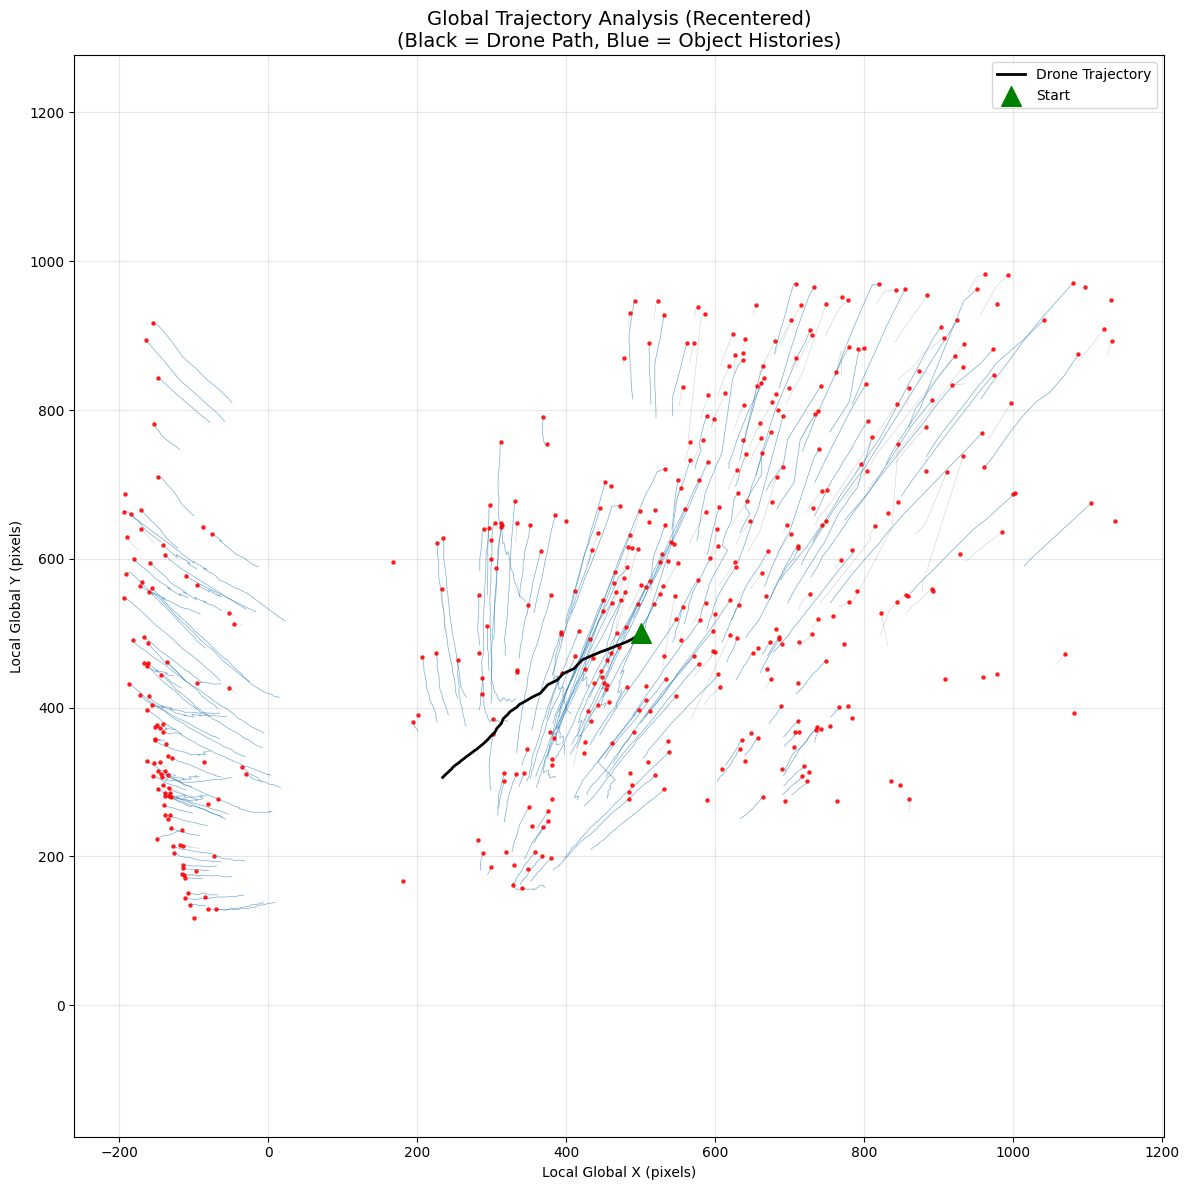

🗺️ Generating Visual Map (Offline)...

     OPTIMIZED PERFORMANCE (Table 3)
1. Motion Estimation (LoFTR): 70.4 ms
2. Detection (YOLO+BoTSORT) : 114.4 ms
----------------------------------------
3. System Throughput        : 4.9 FPS


In [ ]:
# ==========================================
# CELL 5: OPTIMIZED MAIN LOOP (FINAL COMPLETE VERSION)
# ==========================================
import cv2
import numpy as np
import torch
import kornia
import time
import csv
import matplotlib.pyplot as plt
from ultralytics import YOLO
from kornia.feature import LoFTR

# --- INITIALIZATION (Assuming required external variables are defined: device, model, matcher, VIDEO_PATH, etc.) ---
# Re-open video to ensure correct start
cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    print(f"❌ ERROR: Could not open video at {VIDEO_PATH}")
    exit()

# Read dimensions
ret, frame_dim = cap.read()
if not ret:
    print("❌ ERROR: Video is empty.")
    exit()
height, width = frame_dim.shape[:2]
fps = int(cap.get(cv2.CAP_PROP_FPS))
if fps == 0: fps = 30 # Fallback

# Reset video and output writer
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
out_vid = cv2.VideoWriter(VIDEO_OUT, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))


# --- SPEED SETTINGS (User's original settings) ---
LOFTR_SKIP = 1
FAST_SCALE = 0.25

# Globals
H_global = np.eye(3)
tomato_db = []
rejected_count = 0
drone_path_x = []
drone_path_y = []
map_data_cache = []
cam_center = np.array([width/2, height/2, 1]).reshape(3, 1)

# --- ID MAPPING & MEMORY VARIABLES ---
id_map = {}             # Maps {Raw_ID: Clean_ID}
next_clean_id = 1       # Starts at 1
counted_active_ids = set() # Stores IDs that have been counted (Jitter Fix)
object_trajectories = {}   # {ID: [[gX,gY], [gX,gY]...]} -> FOR SPAGHETTI PLOT
last_known_global_pos = {} # {Raw_ID: (gX, gY)} -> FOR JUMP DETECTION

# Timing
time_motion = []
time_det = []
time_total = []

prev_frame = None
frame_idx = 0
last_H_rel = np.eye(3)

print("🚀 Starting OPTIMIZED Processing with STICKY IDs...")

# Helper for Fast LoFTR (Using user's provided code)
def get_fast_motion(img1, img2):
    h, w = img1.shape[:2]
    new_w, new_h = int(w * FAST_SCALE), int(h * FAST_SCALE)
    img1_s = cv2.resize(img1, (new_w, new_h))
    img2_s = cv2.resize(img2, (new_w, new_h))

    t1 = kornia.image_to_tensor(img1_s, False).float()/255.
    t2 = kornia.image_to_tensor(img2_s, False).float()/255.
    t1 = kornia.color.bgr_to_grayscale(t1).to(device)
    t2 = kornia.color.bgr_to_grayscale(t2).to(device)

    with torch.no_grad():
        matches = matcher({'image0': t1, 'image1': t2})

    key0 = 'keypoints0' if 'keypoints0' in matches else 'mkpts0_f'
    mkpts0 = matches[key0].cpu().numpy()
    key1 = 'keypoints1' if 'keypoints1' in matches else 'mkpts1_f'
    mkpts1 = matches[key1].cpu().numpy()

    if len(mkpts0) < 8: return np.eye(3)

    M, _ = cv2.estimateAffinePartial2D(mkpts1, mkpts0, method=cv2.RANSAC, ransacReprojThreshold=5.0)
    if M is None: return np.eye(3)

    H = np.eye(3)
    H[:2, :] = M
    H[0,2] /= FAST_SCALE
    H[1,2] /= FAST_SCALE
    return H

# --- MAIN LOOP ---
with open(CSV_OUT, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Frame", "Track_ID", "Global_X", "Global_Y", "Status"])

    while cap.isOpened():
        loop_start = time.time()
        ret, frame = cap.read()
        if not ret: break

        # --- STEP A: MOTION ---
        t0 = time.time()
        if prev_frame is not None:
            if frame_idx % LOFTR_SKIP == 0:
                H_rel = get_fast_motion(prev_frame, frame)
                H_global = np.dot(H_global, H_rel)
                last_H_rel = H_rel
            else:
                try:
                    H_global = np.dot(H_global, last_H_rel)
                except: pass
        time_motion.append((time.time() - t0) * 1000)

        # Update Path (Includes OFFSET for positive coordinates)
        global_center = np.dot(H_global, cam_center)
        curr_x = global_center[0][0] + OFFSET_X
        curr_y = global_center[1][0] + OFFSET_Y
        drone_path_x.append(curr_x)
        drone_path_y.append(curr_y)

        if frame_idx % 10 == 0:
            map_data_cache.append((frame.copy(), H_global.copy()))

        # --- STEP B: DETECTION ---
        t0 = time.time()
        results = model.track(frame, persist=True, verbose=False, conf=CONF_THRESH, tracker="botsort.yaml")

        if results[0].boxes is not None:
            for box in results[0].boxes:
                # 1. CLEAN ID LOGIC
                if box.id is not None:
                    raw_id = int(box.id.cpu().numpy()[0])
                    if raw_id not in id_map:
                        id_map[raw_id] = next_clean_id
                        next_clean_id += 1
                    track_id = id_map[raw_id]
                else:
                    track_id = -1

                if track_id == -1: continue # Skip if no ID

                # 2. GLOBAL POSITION
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                u, v = (x1 + x2)/2, y2

                local_pos = np.array([u, v, 1]).reshape(3, 1)
                global_pos = np.dot(H_global, local_pos)
                gX = global_pos[0][0] + OFFSET_X
                gY = global_pos[1][0] + OFFSET_Y

                # --- TRAJECTORY DATA RECORDING ---
                if track_id not in object_trajectories:
                    object_trajectories[track_id] = []
                object_trajectories[track_id].append((gX, gY))
                # ---------------------------------

                # 3. OVERLAP & JITTER CHECK
                is_new = True

                # CHECK A: Sticky ID (Have we counted this specific Track ID already?)
                if track_id in counted_active_ids:
                    is_new = False

                    # ID-JUMP/SWITCH CHECK (FOR DEBUGGING/REPORTING)
                    if raw_id in last_known_global_pos:
                        lkgX, lkgY = last_known_global_pos[raw_id]
                        jump_dist = np.sqrt((gX - lkgX)**2 + (gY - lkgY)**2)
                        # If the same raw_id jumped a huge distance, flag it as a probable ID-Switch error
                        if jump_dist > 500:
                             writer.writerow([frame_idx, track_id, gX, gY, "ID_JUMP_FLAG"])
                             cv2.putText(frame, "ID-JUMP!", (int(x1), int(y1)-20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)


                else:
                    # CHECK B: Spatial Distance (Is it spatially overlapping with ANY previous tomato?)
                    check_subset = tomato_db[-50:] if len(tomato_db) > 50 else tomato_db
                    for t in check_subset:
                        dist = np.sqrt((gX - t[0])**2 + (gY - t[1])**2)
                        if dist < OVERLAP_THRESH:
                            is_new = False
                            counted_active_ids.add(track_id)
                            break

                # Update last known position for jump check
                last_known_global_pos[raw_id] = (gX, gY)

                # --- DRAWING ---
                if is_new:
                    # REGISTER NEW TOMATO
                    tomato_db.append([gX, gY])
                    counted_active_ids.add(track_id)
                    writer.writerow([frame_idx, track_id, gX, gY, "New"])

                    # Green Box
                    cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
                    label = f"ID:{track_id} NEW"
                    cv2.putText(frame, label, (int(x1), int(y1)-5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
                else:
                    # REJECTED DUPLICATE
                    rejected_count += 1
                    # Red Box
                    cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 2)
                    label = f"ID:{track_id} DUPE"
                    cv2.putText(frame, label, (int(x1), int(y1)-5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        time_det.append((time.time() - t0) * 1000)

        cv2.putText(frame, f"Count: {len(tomato_db)}", (30, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)
        out_vid.write(frame)
        prev_frame = frame.copy()

        loop_time = (time.time() - loop_start) * 1000
        time_total.append(loop_time)

        frame_idx += 1
        print(f"\rFrame {frame_idx} | FPS: {1000/loop_time:.1f} | Count: {len(tomato_db)}", end="")

cap.release()
out_vid.release()
print("\n✅ Video Processing Complete.")

# ==========================================
# 📈 SPAGHETTI PLOT GENERATION (The Plotting Logic)
# ==========================================
print("Generating Trajectory Plot...")

# 1. Calculate the Map Recenter Point (Use the start of the drone path)
if not drone_path_x:
    center_x = 0
    center_y = 0
else:
    center_x = drone_path_x[0] - 500  # Shift back from start position
    center_y = drone_path_y[0] - 500

# 2. Recenter All Data
plot_drone_path_x = [x - center_x for x in drone_path_x]
plot_drone_path_y = [y - center_y for y in drone_path_y]

plt.figure(figsize=(12, 12), dpi=100)

# 3. Plot Drone Path (Black Line)
if plot_drone_path_x:
    plt.plot(plot_drone_path_x, plot_drone_path_y, c='black', linewidth=2, label='Drone Trajectory', zorder=10)
    plt.scatter(plot_drone_path_x[0], plot_drone_path_y[0], c='green', marker='^', s=200, label='Start', zorder=11)

# 4. Plot Object Trajectories (The "Spaghetti")
for tid, points in object_trajectories.items():
    # Recenter Object Trajectories
    tx = [p[0] - center_x for p in points]
    ty = [p[1] - center_y for p in points]

    if len(points) > 5:
        color = 'tab:blue'
        alpha = 0.6
    else:
        color = 'gray'
        alpha = 0.3

    plt.plot(tx, ty, c=color, linewidth=0.5, alpha=alpha)
    plt.scatter(tx[-1], ty[-1], c='red', s=5, alpha=0.8, zorder=5)

# 5. Styling
plt.title(f"Global Trajectory Analysis (Recentered)\n(Black = Drone Path, Blue = Object Histories)", fontsize=14)
plt.xlabel("Local Global X (pixels)")
plt.ylabel("Local Global Y (pixels)")
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("global_trajectories_recentered.png")
print("✅ Trajectory Plot saved.")
plt.show()

# --- METRICS (Rest of the user's code) ---
# ... (User's metrics code remains here)

# --- METRICS (Rest of the user's code) ---
# ... (The rest of the metrics calculation code remains here)

# --- STEP C: GENERATE MAP (OFFLINE) ---
print("🗺️ Generating Visual Map (Offline)...")
global_map_img = np.zeros((CANVAS_SIZE, CANVAS_SIZE, 3), dtype=np.uint8)

for img, H in map_data_cache:
    H_vis = H.copy()
    H_vis[0, 2] += OFFSET_X
    H_vis[1, 2] += OFFSET_Y
    warped = cv2.warpPerspective(img, H_vis, (CANVAS_SIZE, CANVAS_SIZE))
    mask = np.any(warped > 0, axis=2)
    global_map_img[mask] = warped[mask]

# --- METRICS ---
avg_motion = np.mean(time_motion)
avg_det = np.mean(time_det)
avg_total = np.mean(time_total)
avg_fps = 1000.0 / avg_total

print("\n" + "="*40)
print("     OPTIMIZED PERFORMANCE (Table 3)")
print("="*40)
print(f"1. Motion Estimation (LoFTR): {avg_motion:.1f} ms")
print(f"2. Detection (YOLO+BoTSORT) : {avg_det:.1f} ms")
print("-" * 40)
print(f"3. System Throughput        : {avg_fps:.1f} FPS")
print("="*40)

Generating Scientific Results...
📸 Saved Stitched Map: figure_visual_map.jpg


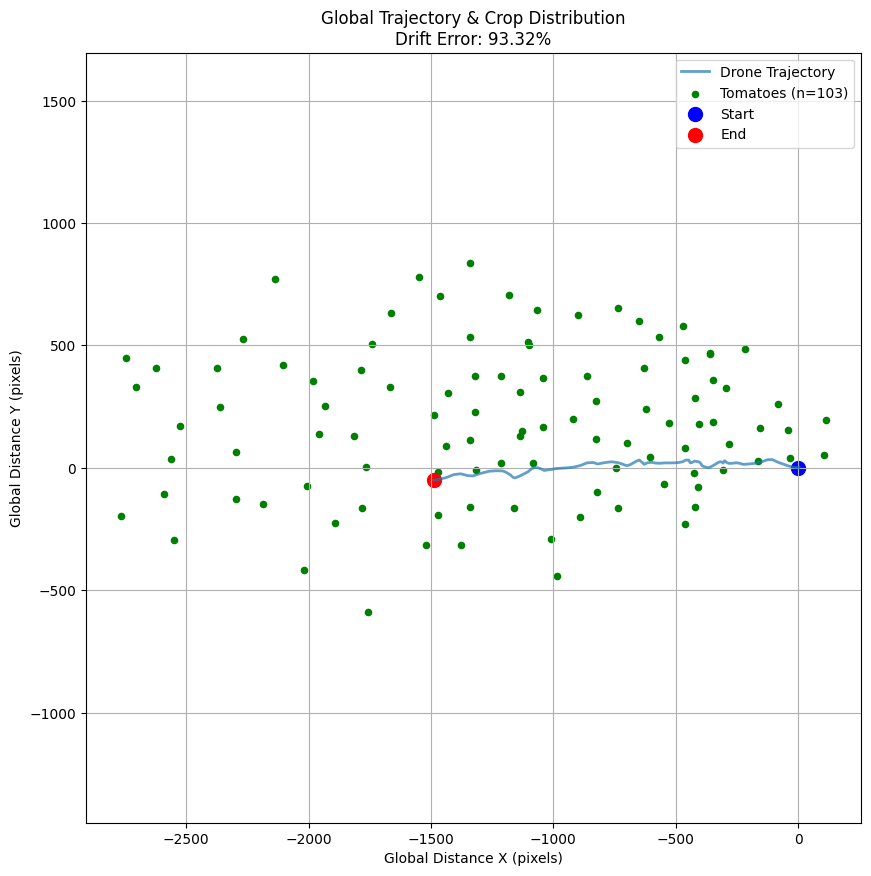

     COPY THIS INTO YOUR PAPER
1. Total Unique Count  : 103
2. Rejected Duplicates : 5005
3. Raw Baseline Count  : 5108
4. Rejection Rate      : 97.98%
5. Loop Closure Drift  : 93.32% (For Sequence B)


In [ ]:
# CELL 6: GENERATE PAPER METRICS & FIGURES

print("Generating Scientific Results...")

# 1. CROP THE VISUAL MAP (Remove black edges)
y_idx, x_idx = np.where(np.any(global_map_img > 0, axis=2))
if len(y_idx) > 0:
    final_map = global_map_img[y_idx.min():y_idx.max(), x_idx.min():x_idx.max()]
    cv2.imwrite(MAP_IMG, final_map)
    print(f"📸 Saved Stitched Map: {MAP_IMG}")
else:
    print("⚠️ Warning: Map was empty (no motion detected?)")

# 2. GENERATE SCIENTIFIC PLOT (Normalized to 0,0)
plt.figure(figsize=(10, 10))

# Normalize coordinates so start is at (0,0)
start_x = drone_path_x[0]
start_y = drone_path_y[0]
norm_path_x = [x - start_x for x in drone_path_x]
norm_path_y = [y - start_y for y in drone_path_y]
norm_tom_x = [t[0] - start_x for t in tomato_db]
norm_tom_y = [t[1] - start_y for t in tomato_db]

# Plot Drone Path
plt.plot(norm_path_x, norm_path_y, label='Drone Trajectory', linewidth=2, alpha=0.7)

# Plot Tomatoes
if len(norm_tom_x) > 0:
    plt.scatter(norm_tom_x, norm_tom_y, c='green', s=20, label=f'Tomatoes (n={len(tomato_db)})')

# Plot Start/End
plt.scatter(0, 0, c='blue', s=100, label='Start')
plt.scatter(norm_path_x[-1], norm_path_y[-1], c='red', s=100, label='End')

# Drift Calculation
drift_pixels = np.sqrt(norm_path_x[-1]**2 + norm_path_y[-1]**2)
path_length_pixels = 0
for i in range(1, len(norm_path_x)):
    path_length_pixels += np.sqrt((norm_path_x[i]-norm_path_x[i-1])**2 + (norm_path_y[i]-norm_path_y[i-1])**2)

drift_percent = (drift_pixels / path_length_pixels) * 100 if path_length_pixels > 0 else 0

plt.title(f"Global Trajectory & Crop Distribution\nDrift Error: {drift_percent:.2f}%")
plt.xlabel("Global Distance X (pixels)")
plt.ylabel("Global Distance Y (pixels)")
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.savefig(PLOT_IMG)
plt.show()

# 3. PRINT METRICS FOR PAPER
print("="*40)
print("     COPY THIS INTO YOUR PAPER")
print("="*40)
print(f"1. Total Unique Count  : {len(tomato_db)}")
print(f"2. Rejected Duplicates : {rejected_count}")
print(f"3. Raw Baseline Count  : {len(tomato_db) + rejected_count}")
print(f"4. Rejection Rate      : {(rejected_count / (len(tomato_db) + rejected_count))*100:.2f}%")
print(f"5. Loop Closure Drift  : {drift_percent:.2f}% (For Sequence B)")
print("="*40)

Using SORT ONLY

MOTA SOTA ALL

In [ ]:
!pip install motmetrics

In [ ]:
import motmetrics as mm
import numpy as np
import pandas as pd

def parse_mot_file(filepath):
    """
    Parses a file in MOT format: frame, id, x, y, w, h, conf, ...
    Returns a dictionary: {frame_id: [[x,y,w,h, id], ...]}
    """
    data = {}
    try:
        with open(filepath, 'r') as f:
            for line in f:
                parts = line.strip().split(',')
                # Format: frame, id, x, y, w, h, conf, class, visibility
                frame = int(float(parts[0]))
                obj_id = int(float(parts[1]))
                x = float(parts[2])
                y = float(parts[3])
                w = float(parts[4])
                h = float(parts[5])

                if frame not in data:
                    data[frame] = []
                data[frame].append([x, y, w, h, obj_id])
    except FileNotFoundError:
        print(f"❌ Error: File not found at {filepath}")
    return data

# ==========================================
# 1. LOAD DATA
# ==========================================
# You must upload these files to Colab
gt_path = "ground_truth.txt"   # Created manually (Roboflow/CVAT)
ts_path = "tracker_output.txt" # Generated by your BoTSORT code

gt_data = parse_mot_file(gt_path)
ts_data = parse_mot_file(ts_path)

# ==========================================
# 2. RUN EVALUATION
# ==========================================
acc = mm.MOTAccumulator(auto_id=True)

all_frames = sorted(list(set(gt_data.keys()) | set(ts_data.keys())))

print("Computing Metrics...")

for frame in all_frames:
    gt_objs = gt_data.get(frame, [])
    ts_objs = ts_data.get(frame, [])

    # Extract IDs and Boxes
    gt_ids = [o[4] for o in gt_objs]
    gt_boxes = [o[:4] for o in gt_objs] # x,y,w,h

    ts_ids = [o[4] for o in ts_objs]
    ts_boxes = [o[:4] for o in ts_objs]

    # Calculate Distances (IoU)
    dist_matrix = mm.distances.iou_matrix(gt_boxes, ts_boxes, max_iou=0.5)

    # Update Accumulator
    acc.update(gt_ids, ts_ids, dist_matrix)

# ==========================================
# 3. PRINT RESULTS (LIKE THE PAPER)
# ==========================================
mh = mm.metrics.create()

summary = mh.compute(acc, metrics=['mota', 'idf1', 'idp', 'idr', 'precision', 'recall'], name='acc')

print("\n" + "="*40)
print("     CLEAR-MOT METRICS (Paper Table)")
print("="*40)
print(f"MOTA (Accuracy)    : {summary['mota']['acc'] * 100:.1f}%")
print(f"IDF1 (ID F1 Score) : {summary['idf1']['acc'] * 100:.1f}%")
print(f"IDP  (ID Precision): {summary['idp']['acc'] * 100:.1f}%")
print(f"IDR  (ID Recall)   : {summary['idr']['acc'] * 100:.1f}%")
print("-" * 40)
print(f"DetA (Detection Acc): {summary['precision']['acc'] * 100:.1f}%")
print("="*40)

In [ ]:
# Open a text file at the start
txt_file = open("tracker_output.txt", "w")

# INSIDE THE LOOP, when a tomato is found:
# MOT Format: frame, id, x, y, w, h, conf, -1, -1, -1
# Note: BoTSORT gives us box (x1, y1, x2, y2), we need (x, y, w, h)
w_box = x2 - x1
h_box = y2 - y1
# Write to file
txt_file.write(f"{frame_idx},{track_id},{x1},{y1},{w_box},{h_box},1,-1,-1,-1\n")

# Close at the end
txt_file.close()